## Initialize

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import  Path
import pandas as pd
import numpy as np
import plotly as pl, plotly_express as pe

from collections import Iterable
from itertools import chain
from src.utils import add_datepart, apply_cats, get_cv_idxs, proc_df
from src.datasets import ColumnarDataLoader

import tqdm
from tqdm.notebook import trange

data = Path('/tmp//myapp/data')
data.exists()

<ipython-input-2-57420c3057a8>:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable


True

## 00 Reading data

In [3]:
files = sorted(data.glob('*.csv'))
tables = [pd.read_csv(f, low_memory=False) for f in files]

googletrend, sample, state_names, store, store_states, test, train, weather = tables

## 01 Cleaning Data

In [10]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday  = test.StateHoliday!='0'

In [11]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [12]:
weather = join_df(weather, state_names, "file", "StateName")

In [13]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [19]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

/tmp/myapp/src/utils.py:76: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())


In [22]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [23]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [25]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [26]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [27]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [28]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [29]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [30]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [31]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [32]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Treat variables as categorical as possible

In [34]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,
        1, 14, 20,  8, 18,  6, 21,  5])

In [35]:
from datetime import datetime, timedelta, date
def first_date(year, week):
    ret = datetime.strptime('%04d-%02d-1' % (year, week), '%Y-%W-%w')
    if date(year, 1, 4).isoweekday() > 4:
        ret -= timedelta(days=7)
    return ret

In [36]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: first_date(
        x.Promo2SinceYear, x.Promo2SinceWeek), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [37]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [38]:
joined.to_parquet(data / 'joined.p')
joined_test.to_parquet(data / 'joined_test.p')

train.to_parquet(data / 'train.p')
test.to_parquet(data / 'test.p')

## 02 Exploration of cleaned data

In [39]:
joined = pd.read_parquet(data / 'joined.p')
joined_test = pd.read_parquet(data / 'joined_test.p')

In [45]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,6.0,None,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,4.0,None,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0


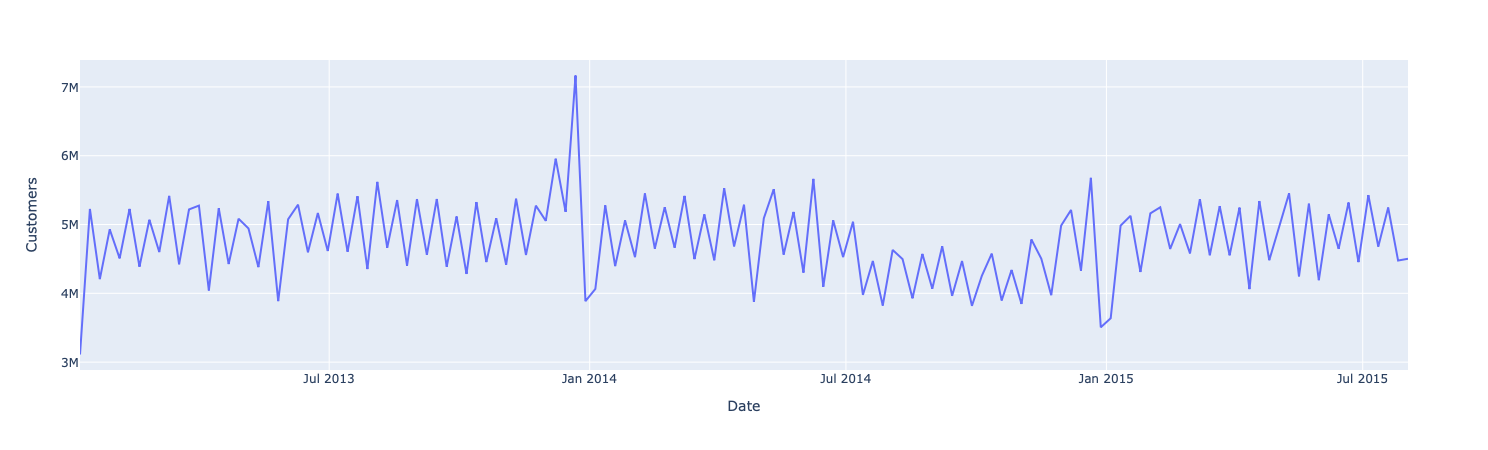

In [44]:
joined_W = joined.set_index('Date').resample('W')['Customers'].sum().reset_index()
pe.line(data_frame=joined_W, x='Date',y='Customers')

## 03 Adding durations

In [24]:
joined       = pd.read_parquet(data / 'joined.p')
joined_test  = pd.read_parquet(data / 'joined_test.p')

train = pd.read_parquet(data  / 'train.p')
test  = pd.read_parquet(data / 'test.p')

In [49]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [50]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]
df = train[columns].append(test[columns])

In [51]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'],)
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [54]:
df = df.set_index("Date")

In [55]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [56]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [57]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [59]:
df.drop(columns,1,inplace=True)

In [60]:
joined = join_df(joined, df, ['Store', 'Date'])
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [61]:
joined = joined[joined.Sales!=0]

In [62]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [37]:
joined.to_parquet(data / 'joined.p')
joined_test.to_parquet(data / 'joined_test.p')